# TimeGrad: Training and Inference on S&P500 Data

This notebook demonstrates how to run the TimeGrad model on S&P500 time-series data. It covers:

1.  **Data Fetching**: Downloading S&P500 data using `yfinance`.
2.  **Data Preparation**: Normalizing and converting data into a GluonTS-compatible format.
3.  **Model Training**: Training the TimeGrad model using a simplified Dataloader.
4.  **Inference**: Generating synthetic time-series samples using the trained model.
5.  **Visualization**: Comparing the synthetic data with the real data.

In [2]:
import sys
import os
from typing import List
import torch
import matplotlib.pyplot as plt
import numpy as np

# Add the project's root directory to the Python path.
# This allows us to import our custom modules like `data_fetch` and `src.pts`.
module_path = os.path.abspath(os.getcwd()) # Assumes notebook is in 'Grok Assisted' directory
if module_path not in sys.path:
    sys.path.insert(0, module_path)

from gluonts.dataset.split import split

# Import from the modules directly
from src.pts.model.time_grad.diffusion import Diffusion, DiffusionConfig
from src.pts.model.time_grad.time_grad_network import TimeGradNetwork, NetworkConfig
from src.pts.model.time_grad.time_grad_estimator import TimeGradEstimator, EstimatorConfig
from src.pts.model.time_grad.time_grad_predictor import TimeGradPredictor
from src.pts.trainer import Trainer
from data_fetch import fetch_sp500_data, prepare_gluonts_dataset, DataConfig

print("Imports successful and path is set up.")

Imports successful and path is set up.


/opt/conda/envs/condatest/lib/python3.9/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


## 1. Configuration

We define all the configurations for data, network, diffusion, and the estimator in one place.

In [19]:
# Data Configuration
# Use daily data ('1d') to fetch the full history from 2010.
# yfinance limits hourly ('1h') data to the last ~2 years.
data_config = DataConfig(
    symbol= 'BTC-USD',
    start_date='2020-01-01', 
    interval='1d',
    context_length=24, 
    prediction_length=24
)

# Network configuration
net_config = NetworkConfig(input_dim=1, hidden_dim=40, num_layers=2)

# Diffusion process configuration
diff_config = DiffusionConfig(num_steps=100, beta_start=1e-4, beta_end=0.1)

# Estimator/Training configuration
est_config = EstimatorConfig(learning_rate=1e-3, batch_size=64)

print("Configurations loaded.")

Configurations loaded.


## 2. Data Fetching and Preparation

We fetch the S&P 500 data, normalize it, and prepare it as a GluonTS dataset.

In [22]:
try:
    print("Fetching data...")
    # Fetch data
    df = fetch_sp500_data(data_config)
    print(f"Fetched {len(df)} data points")

    # Simple normalization
    data_mean = df['close'].mean()
    data_std = df['close'].std()
    df_normalized = df.copy()
    df_normalized['close'] = (df['close'] - data_mean) / data_std
    print(f"Data normalized - Mean: {data_mean:.2f}, Std: {data_std:.2f}")

    # Create dataset
    dataset = prepare_gluonts_dataset(df_normalized, data_config)
    print("Dataset prepared successfully")
except Exception as e:
    print(f"An error occurred during data fetching/preparation: {e}")

[*********************100%***********************]  1 of 1 completed

Fetching data...
Fetched 2069 data points
Data normalized - Mean: 43869.58, Std: 28988.19
Dataset prepared successfully


## 3. Data Splitting and Dataloader

The data is split into training and test sets. We then use a simple, custom data loader for training. This loader yields batches with the target data and initial hidden states for the RNN.

In [23]:
# Split data
# We only need the training part from the split for this script.
train_dataset, _ = split(dataset, offset=-data_config.prediction_length)
train_data = list(train_dataset)
        
print(f"Training data: {len(train_data)} series")

# Simple dataloader
class SimpleLoader:
    def __init__(self, ds, context_length, num_layers, hidden_dim):
        self.ds = ds
        self.context_length = context_length
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
                
    def __iter__(self):
        for item in self.ds:
            target_data = item['target']

            # Create sliding windows over the entire training series
            # to ensure the model sees all the data.
            for i in range(len(target_data) - self.context_length + 1):
                context_data = target_data[i : i + self.context_length]
                target_tensor = torch.tensor(
                    context_data.reshape(1, -1, 1), 
                    dtype=torch.float32
                )

                hidden = (
                    torch.zeros(self.num_layers, 1, self.hidden_dim),
                    torch.zeros(self.num_layers, 1, self.hidden_dim)
                )

                yield {
                    'target': target_tensor,
                    'hidden': hidden
                }

    def __len__(self):
        # The length is the total number of windows we can create.
        total_windows = 0
        for item in self.ds:
            total_windows += max(0, len(item['target']) - self.context_length + 1)
        return total_windows

train_loader = SimpleLoader(
    train_data, 
    data_config.context_length, 
    net_config.num_layers, 
    net_config.hidden_dim
)

print("Dataloader created.")

Training data: 1 series
Dataloader created.


## 4. Model Initialization

We initialize the core components of TimeGrad: the diffusion process, the noise prediction network, the estimator (which handles the loss), and the trainer.

In [24]:
print("Initializing models...")
# Initialize models
diffusion = Diffusion(diff_config)
network = TimeGradNetwork(net_config)
estimator = TimeGradEstimator(est_config, network, diffusion)
trainer = Trainer(estimator, epochs=10)

print("Models initialized.")

Initializing models...
Models initialized.


## 5. Training

Now, we train the model. The progress bar will show the status for each epoch.

In [25]:
print("Starting training...")
losses = trainer.train(train_loader)
print(f"Training completed. Final loss: {losses[-1]:.4f}")

Starting training...


100%|██████████| 2022/2022 [00:04<00:00, 435.95it/s]


Epoch 0 loss: 1.0086181646638526


100%|██████████| 2022/2022 [00:04<00:00, 447.12it/s]


Epoch 1 loss: 0.9873814896176524


100%|██████████| 2022/2022 [00:04<00:00, 466.61it/s]


Epoch 2 loss: 0.9998754181122568


100%|██████████| 2022/2022 [00:04<00:00, 437.38it/s]


Epoch 3 loss: 0.9999681466160495


100%|██████████| 2022/2022 [00:05<00:00, 393.49it/s]


Epoch 4 loss: 1.0024273864165847


100%|██████████| 2022/2022 [00:05<00:00, 350.30it/s]


Epoch 5 loss: 1.0102299323893207


100%|██████████| 2022/2022 [00:04<00:00, 418.10it/s]


Epoch 6 loss: 1.001675745404144


100%|██████████| 2022/2022 [00:08<00:00, 252.13it/s]


Epoch 7 loss: 0.9941880019228725


100%|██████████| 2022/2022 [00:05<00:00, 372.64it/s]


Epoch 8 loss: 0.9883568576665118


100%|██████████| 2022/2022 [00:06<00:00, 326.98it/s]

Epoch 9 loss: 1.0048582453195938
Training completed. Final loss: 1.0049


## 6. Inference: Generating Synthetic Samples

With the trained network, we use the `TimeGradPredictor` to generate new time-series samples through the reverse diffusion process.

In [13]:
print("Generating synthetic samples...")
# Generate samples
predictor = TimeGradPredictor(network, diffusion)
samples = predictor.predict(
    context_length=data_config.prediction_length, 
    num_samples=100
)
print(f"Generated samples shape: {samples.shape}")

Generating synthetic samples...
Generated samples shape: torch.Size([100, 24])


## 7. Visualization and Analysis

Finally, we visualize the results. We denormalize the generated samples and plot them against the original data to qualitatively assess the model's performance.

Creating forecast visualization...


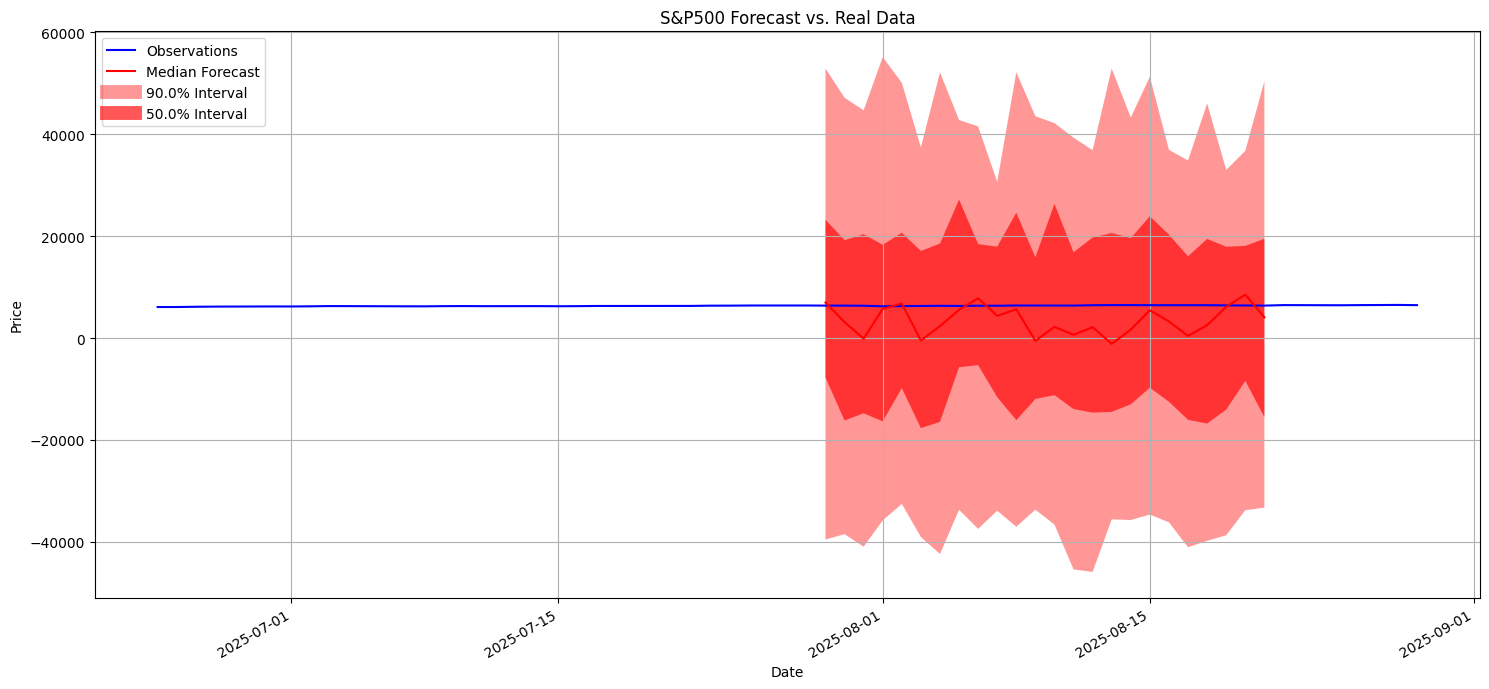


=== Results Summary ===
Real data      - Mean: 6402.55, Std: 65.40
Median forecast - Mean: 3460.45, Std: 2783.83


In [17]:
import pandas as pd

# Helper class to mimic GluonTS/PyTorchTS Forecast object
def plot_forecast(
    target: pd.Series,
    forecast: SimpleForecast,
    prediction_length: int,
    prediction_intervals: tuple = (50.0, 90.0),
    color: str = "g",
):
    """
    Plots a univariate time series forecast against the target data.

    This is an adaptation of a more general plotting utility to fit the
    univariate case of this notebook. It shows the median forecast and
    prediction intervals.
    """
    print("Creating forecast visualization...")
    # Dynamically adjust plot width based on the number of observations
    dynamic_width = max(15, prediction_length / 4)
    plt.figure(figsize=(dynamic_width, 7))
    ax = plt.gca()

    # Plot the target data, showing some history before the forecast
    # We plot the last 2 * prediction_length to give context
    target_plot_range = target.iloc[-2 * prediction_length :]
    target_plot_range.plot(ax=ax, label="Observations", color="blue")

    # Define the percentiles to calculate for the prediction intervals
    ps = [50.0] + [50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, 1.0]]
    percentiles_sorted = sorted(set(ps))

    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3

    # Get quantile data from the forecast object
    ps_data = [forecast.quantile(p / 100.0) for p in percentiles_sorted]
    i_p50 = len(percentiles_sorted) // 2

    # Plot the median forecast
    p50_data = ps_data[i_p50]
    p50_series = pd.Series(data=p50_data, index=forecast.index)
    p50_series.plot(color=color, ls="-", label="Median Forecast", ax=ax)

    # Plot the prediction intervals as shaded areas
    for i in range(len(percentiles_sorted) // 2):
        ptile = percentiles_sorted[i]
        alpha = alpha_for_percentile(ptile)
        ax.fill_between(
            forecast.index,
            ps_data[i],
            ps_data[-i - 1],
            facecolor=color,
            alpha=alpha,
            interpolate=True,
        )
        # Use a hack to create labels for the prediction intervals in the legend
        pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
            color=color, alpha=alpha, linewidth=10, label=f"{100 - ptile * 2}% Interval", ax=ax,
        )

    ax.legend(loc="upper left")
    plt.title("S&P500 Forecast vs. Real Data")
    plt.ylabel("Price")
    plt.xlabel("Date")
    plt.grid(which="both")
    plt.tight_layout()
    plt.show()

# --- Execution part ---

# 1. Denormalize the generated samples
# Note: `samples` comes from the predictor, `data_std` and `data_mean` from the normalization step.
denormalized_samples = samples.detach().numpy() * data_std + data_mean

# 2. Determine the forecast start date and frequency
# The forecast starts right after the training data ends.
forecast_start_date = df.index[-data_config.prediction_length]
freq = 'h' if data_config.interval == '1h' else 'D'

# 3. Create the forecast object
forecast_obj = SimpleForecast(
    samples=denormalized_samples,
    start_date=forecast_start_date,
    freq=freq
)

# 4. Plot the forecast
# The `target` is the full historical data series.
plot_forecast(
    target=df['close'], 
    forecast=forecast_obj, 
    prediction_length=data_config.prediction_length,
    color='r' # Use red for the forecast
)

# 5. Print statistics for comparison
# FIX: Get original_data by slicing the dataframe directly.
# This avoids the NameError with 'test_data'.
original_data = df['close'][-data_config.prediction_length:].values

# FIX: Define median_forecast before using it.
median_forecast = forecast_obj.quantile(0.5)

print("\n=== Results Summary ===")
print(f"Real data      - Mean: {np.mean(original_data):.2f}, Std: {np.std(original_data):.2f}")
print(f"Median forecast - Mean: {np.mean(median_forecast):.2f}, Std: {np.std(median_forecast):.2f}")
